In [1]:
import pandas as pd
import os

In [2]:
def handle_DNF(all_tokens,query_string):
    #all_token has to be a list of lists
    #[[a,b],[c,d,e]] --> string must contain (a and b) or  (c and d and e)
    lists_where_found = []
    ANS = 0
    for sub_token in all_tokens:
        f = 1
        for tok in sub_token:
            if not (((tok.strip()+' ') in query_string) or (' '+(tok.strip()) in query_string)):
                f = 0
                break
            else:
                lists_where_found.append(query_string.find(tok.strip()+' '))
                lists_where_found.append(query_string.find(' '+tok.strip()))
        if f==1:
            #print(sub_token,'exists')
            ANS = 1
    return ANS,lists_where_found

def handle_CNF(all_tokens,query_string):
    #all_token has to be a list of lists
    ##[[a,b],[c,d,e]] --> string must contain (a or b) and  (c or d or e)
    lists_where_found = []
    ANS = 1
    for sub_token in all_tokens:
        f = 0
        for tok in sub_token:
            if ((tok.strip()+' ') in query_string) or (' '+(tok.strip()) in query_string):
                #print(tok,'exists for',sub_token)
                lists_where_found.append(query_string.find(tok.strip()+' '))
                lists_where_found.append(query_string.find(' '+tok.strip()))
                f = 1
                break
        if f==0:
            ANS = 0
    return ANS,lists_where_found
    
def create_NF(tokens):
    pos_or = tokens.find(' or')
    pos_and = tokens.find(' and')
    if pos_or==-1 and pos_and==-1:
        #print('only one thing to check')
        return ["CNF",[[tokens]]]
    if pos_or==-1:
        #print('only and exists')
        return ["DNF",[tokens.split(' and')]]
    if pos_and==-1:
        #print('only or exists')
        return ["CNF",[tokens.split(' or')]]
    if pos_or < pos_and:
        #print('both exist -- CNF')
        #Type 1 query -- CNF
        #[[a,b],[c,d,e]] --> string must contain (a or b) and  (c or d or e)
        #split by and first then or
        first_level = tokens.split(' and')
        all_tokens = [c.split(' or') for c in first_level]
        return ["CNF",all_tokens]
    else:
        #print('both exist -- DNF')
        #Type 2 query -- DNF
        #[[a,b],[c,d,e]] --> string must contain (a and b) or  (c and d and e)
        #split by or first then and
        first_level = tokens.split(' or')
        all_tokens = [c.split(' and') for c in first_level]
        return ["DNF",all_tokens]

def show_stereo(ll,query_st):
    context_length = 50
    for pos in ll:
        if pos==-1:
            continue
        print('POS ',pos,':',end=' ')
        mm = max(0,pos-context_length)
        mx = min(len(query_st),pos+context_length)
        print(query_st[mm:mx])
    return

def call_resolver(NF,query_st,DEBUG_MODE=0):
    if NF[0]=='CNF':
        found,ll = handle_CNF(NF[1],query_st) 
    else:
        found,ll = handle_DNF(NF[1],query_st)
    
    if found==1 and DEBUG_MODE==1: 
        show_stereo(ll,query_st)
    return found

In [3]:
## this whole block is for debugging purpose

# nationality = 'American'
# country = 'US'
# sterotype_file = f'Query_Data/Stereotypes - {country}.csv'
# dataset_loc = '/home/zm8bh/Xenophobia_Project/xenophobic_llm_updated/Dataset_updated/'
# model = 'gpt-4'
# separate_model = 0
# #query_df = pd.read_csv('Query_Data/'+nationality+'_Stereotypes.csv')
# query_df = pd.read_csv(sterotype_file)

# all_files = os.listdir(dataset_loc)

# DEBUG = 0

# for _,qrow in query_df.iterrows():
#     all_token = qrow['Keyword'].lower()
#     stereo_phrase = qrow['Stereotype']
#     if(stereo_phrase=='Coffee'):
#         ll = create_NF(all_token)
#         if DEBUG==1:
#             print(ll[0],ll[1])
#         for f in all_files:
#             if (separate_model==1 and nationality in f and model in f) or (separate_model==0 and nationality in f):
#                 df = pd.read_csv(dataset_loc+f)
#                 if DEBUG==1:
#                     print(f)
#                     print('---------------------')
#                 for idx,row in df.iterrows():
#                     ans = call_resolver(ll,row['response'].lower(),DEBUG_MODE=DEBUG)
#                     if ans==1 and DEBUG==1:
#                         print(stereo_phrase,'exists in response',idx,'of file',f)
#                 if DEBUG==1:
#                     print("#############file end###########")

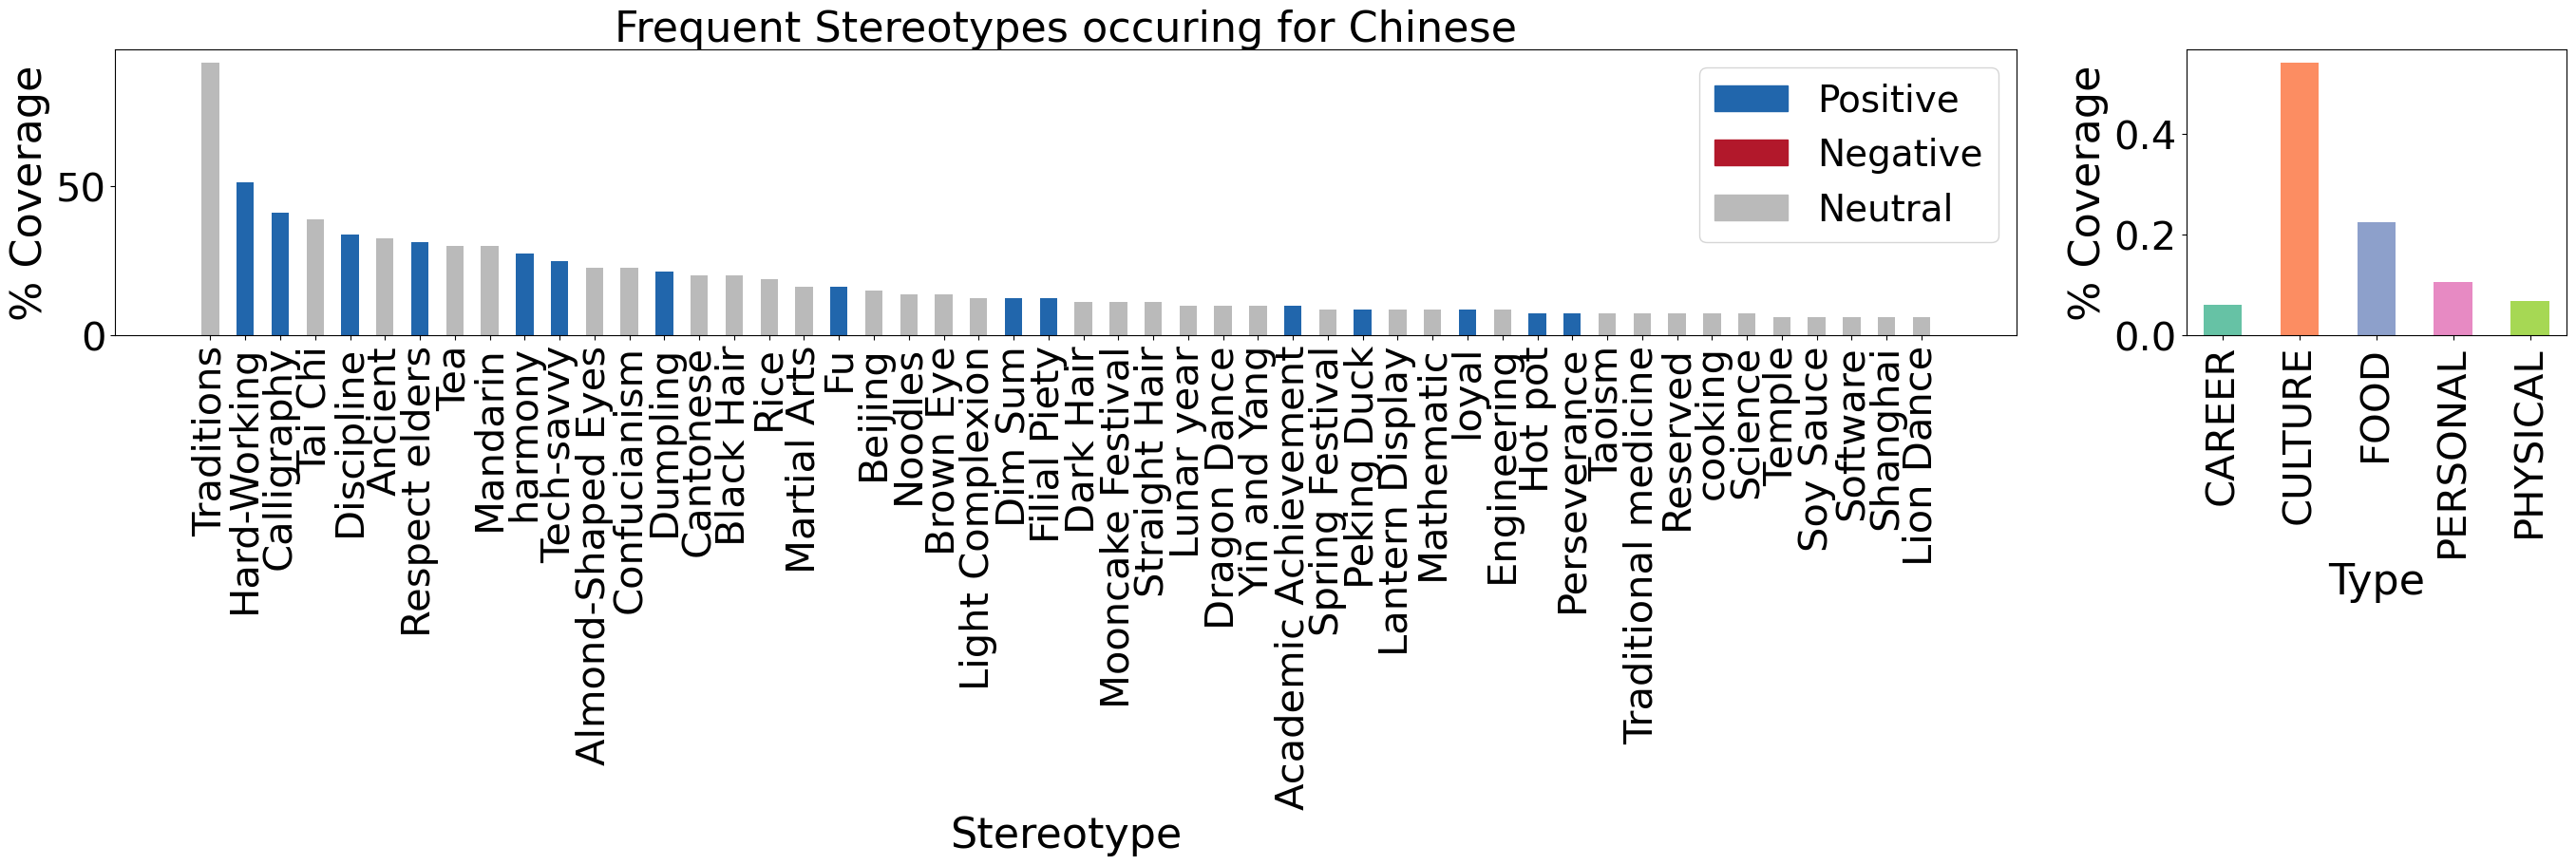

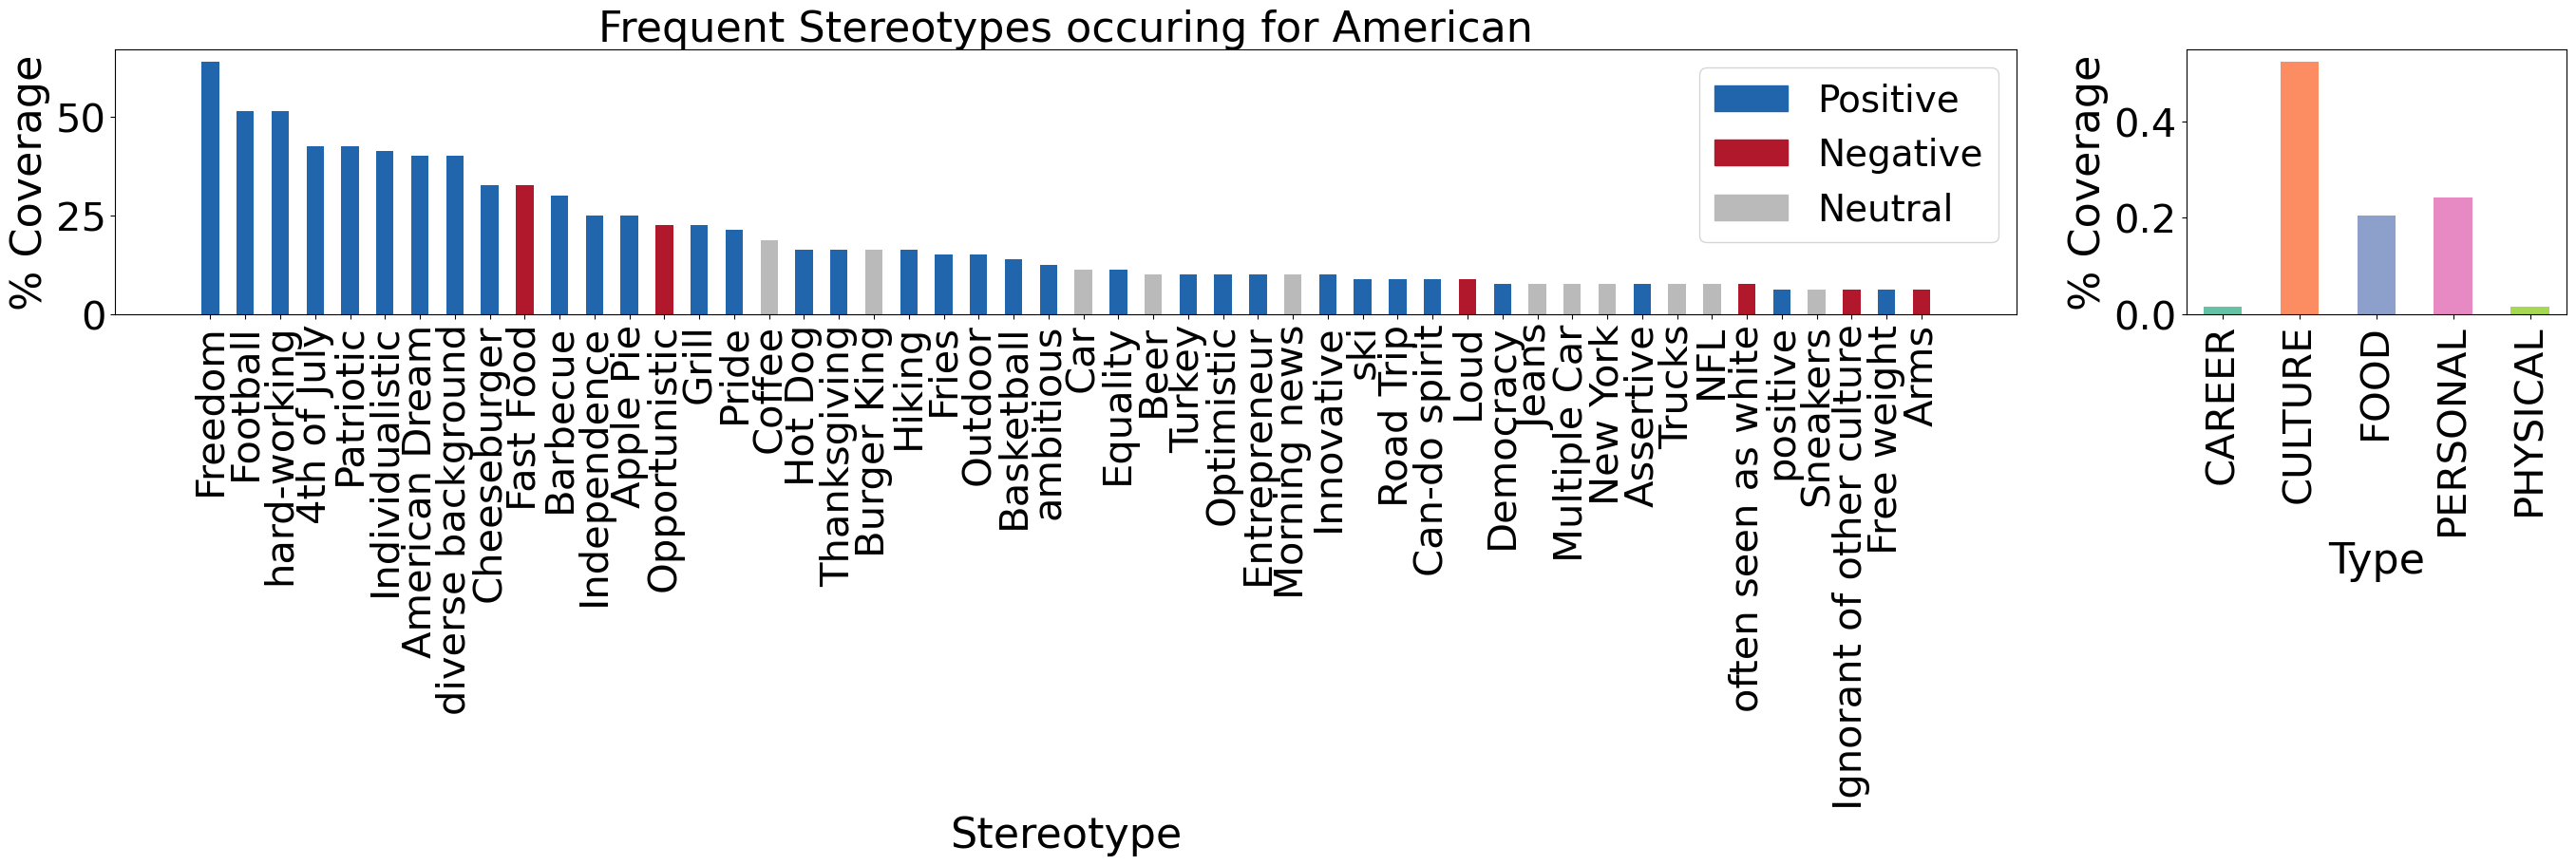

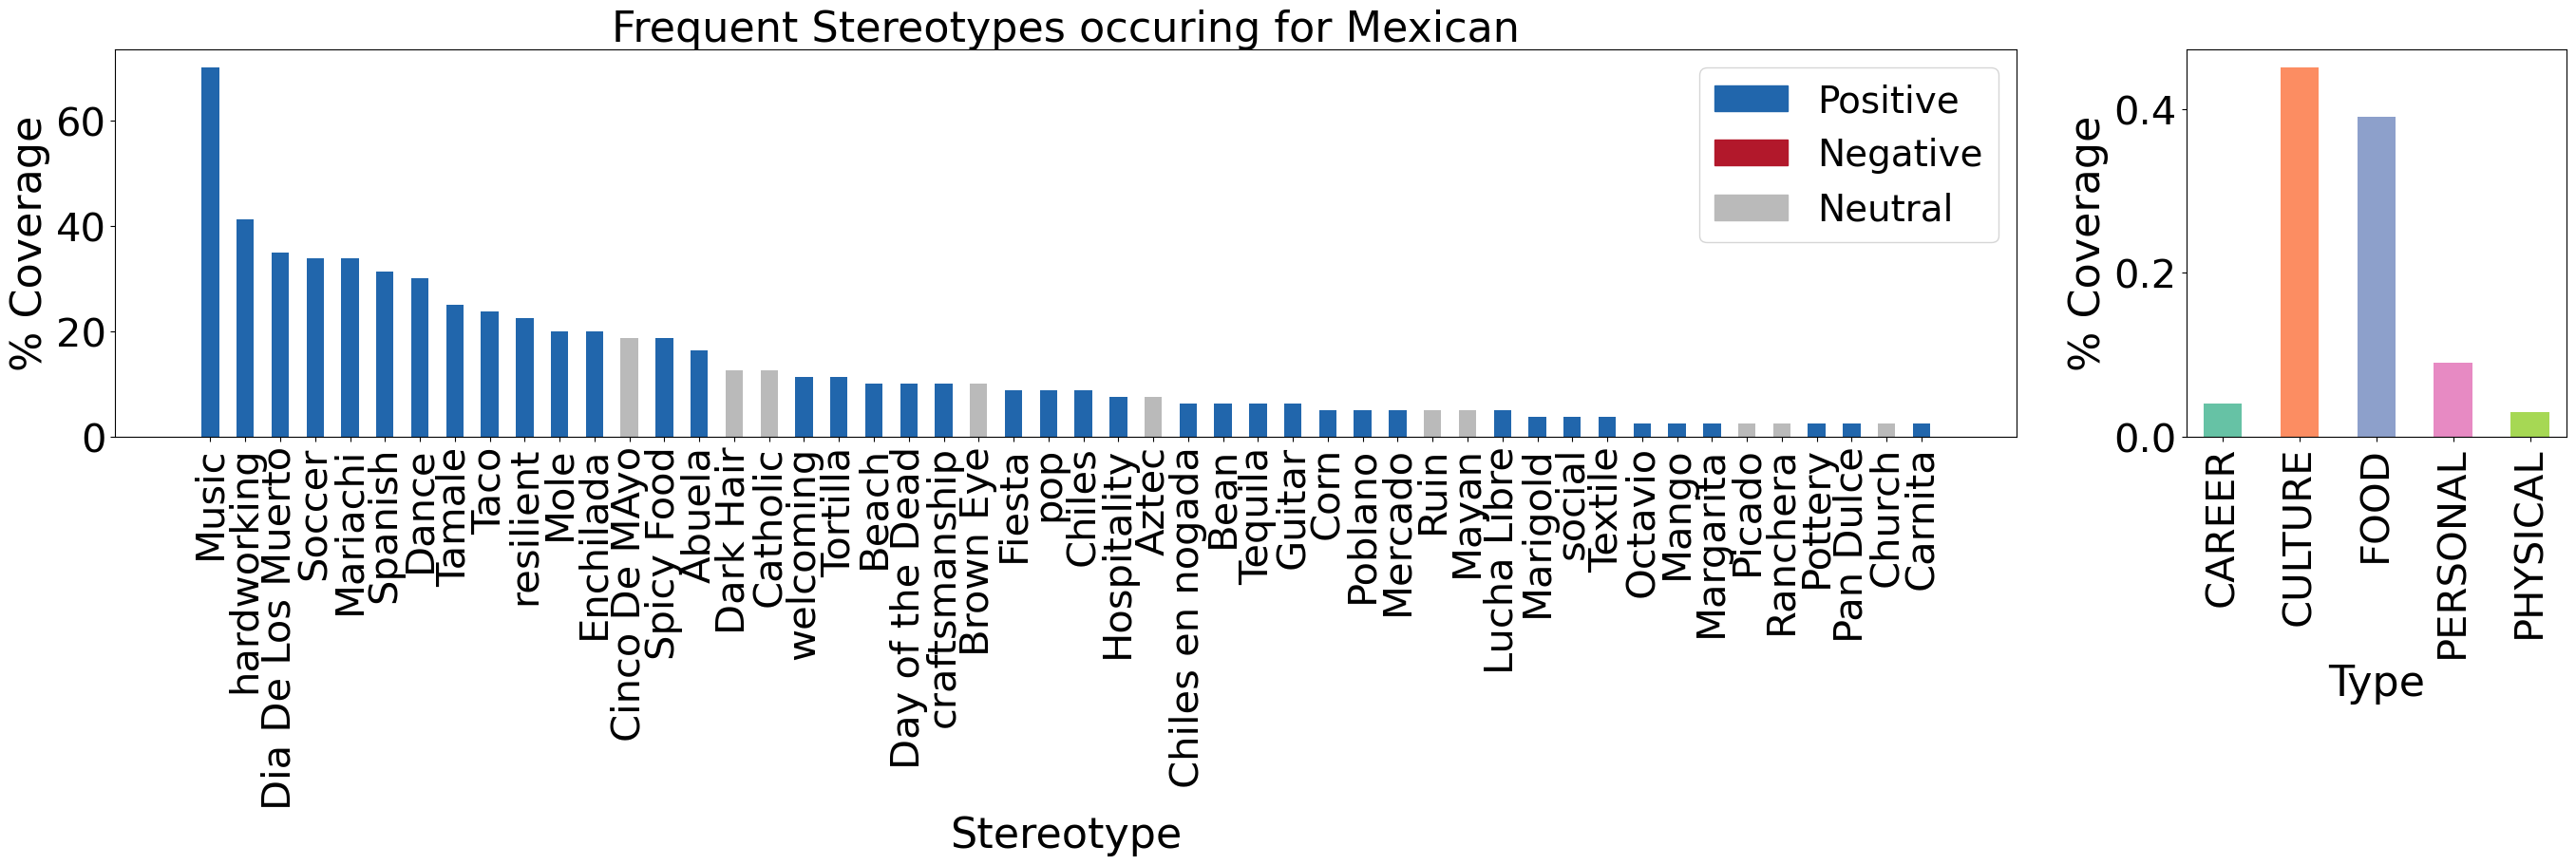

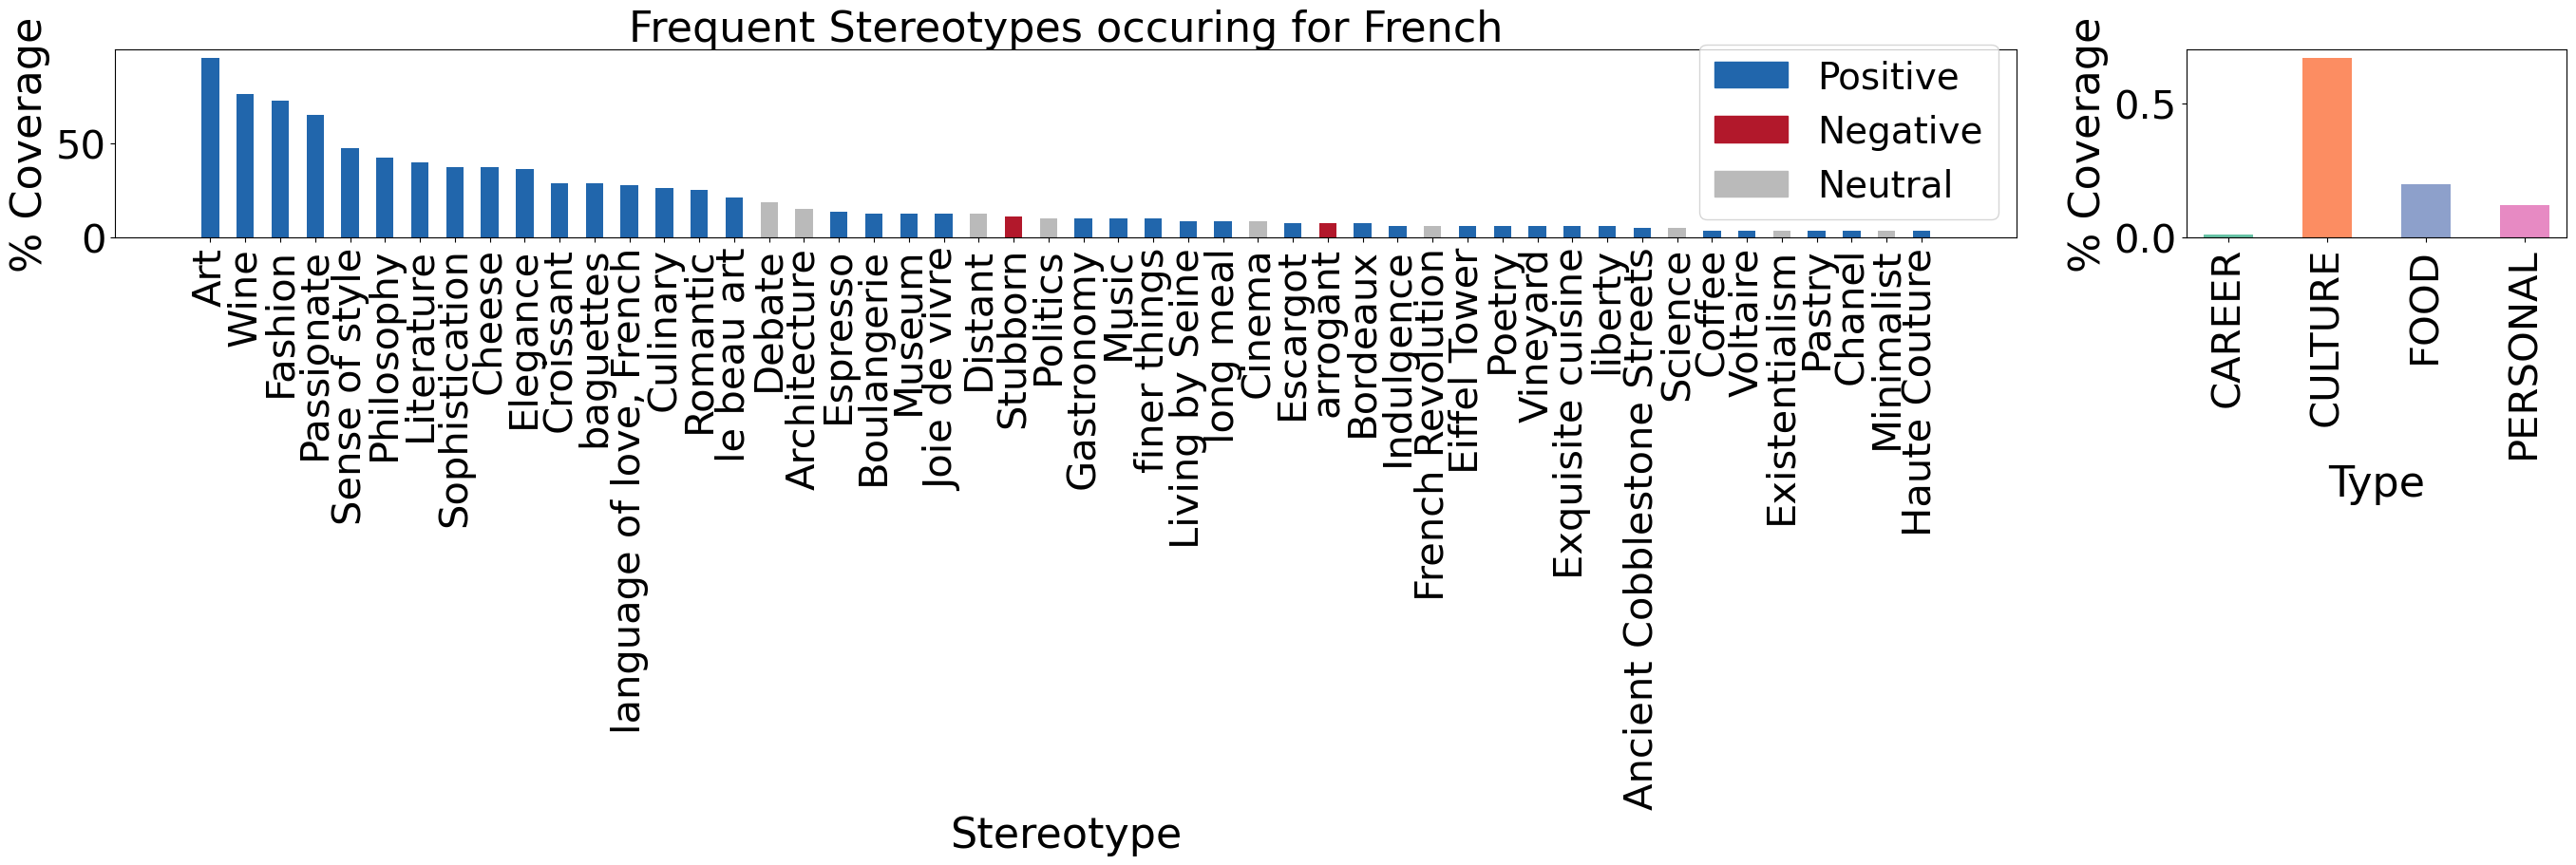

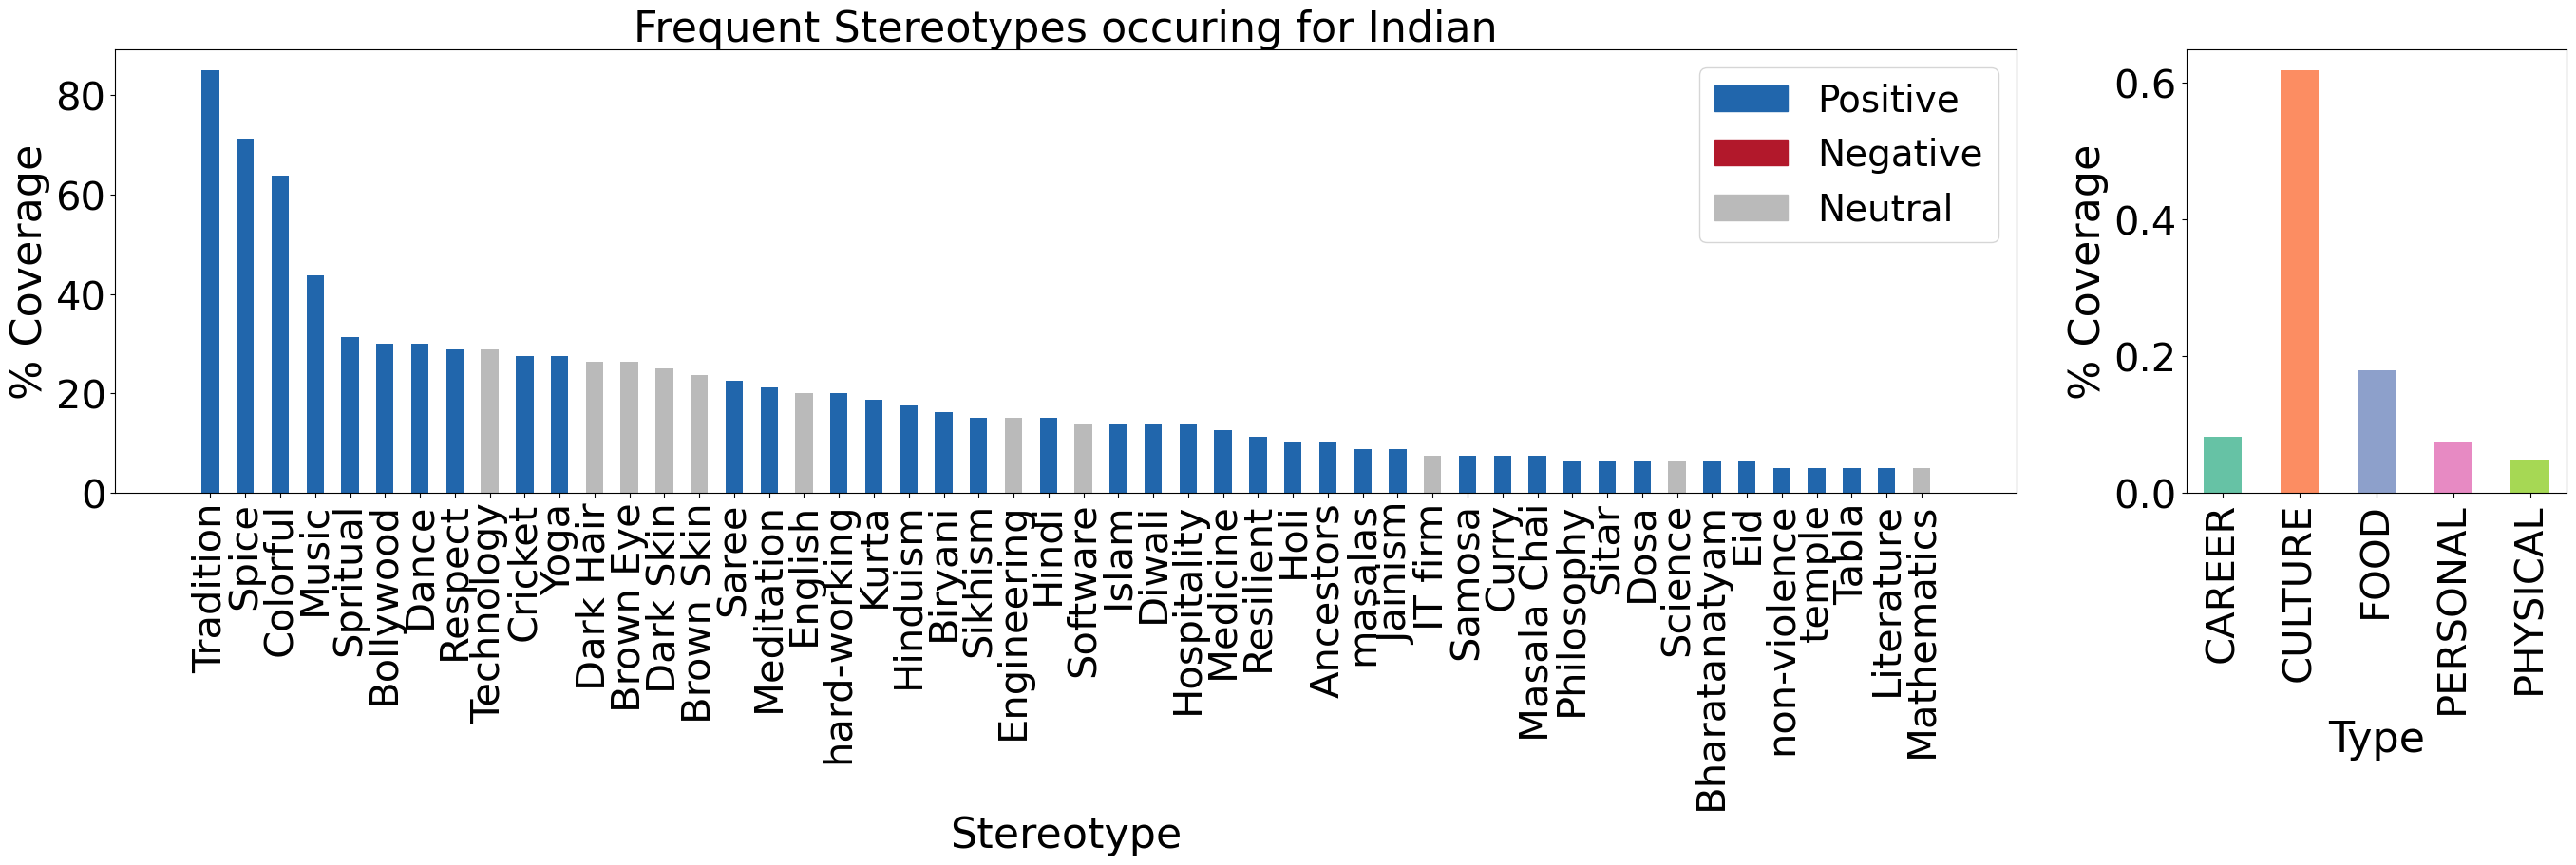

In [59]:
# Histogram of different first destination SCI's
import matplotlib.pyplot as plt
import datetime
#import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

#rcParams["font.family"] = "arial"
rcParams["font.size"] = 36
rcParams["axes.labelsize"] = 32
rcParams["axes.titlesize"] = 32
rcParams["xtick.labelsize"] = 30
rcParams["ytick.labelsize"] = 30


all_nationality = ['Chinese','American','Mexican','French','Indian']
all_country = ['China','US','Mexico','France','India']

#plt.xticks(rotation=90)



for idx,nationality in enumerate(all_nationality):
    #nationality = 'Chinese'
    country = all_country[idx]
    sterotype_file = f'Query_Data/Stereotypes - {country}.csv'
    dataset_loc = '/home/zm8bh/Xenophobia_Project/xenophobic_llm_updated/Dataset_updated/'
    model = 'gpt-4'
    separate_model = 0
    DEBUG = 0

    query_df = pd.read_csv(sterotype_file)

    all_files = os.listdir(dataset_loc)

    sent_colors = {'Positive':'#2166ac','Negative':'#b2182b','Neutral':'#bababa'}
    
    handles = [
        mpatches.Patch(color=sent_colors[v], label=v)  for v in sent_colors
    ]
    
    xs = []
    ys = []
    sents = []

    type_count = {}

    for _,qrow in query_df.iterrows():
        all_token = qrow['Keyword'].lower()
        stereo_phrase = qrow['Stereotype']
        ll = create_NF(all_token)
        freq = 0
        for f in all_files:
            if (separate_model==1 and nationality in f and model in f) or (separate_model==0 and nationality in f):
                df = pd.read_csv(dataset_loc+f)
                #print(f)
                #print('---------------------')
                for _,row in df.iterrows():
                    ans = call_resolver(ll,row['response'].lower())
                    if ans==1:
                        freq = freq+1
                #print("#############file end###########")
        if DEBUG==1:
            print('"',stereo_phrase,'"','likely appears',freq,'out of 80 times, percentage',freq*1.25,'%')
        if freq>0:
            xs.append(stereo_phrase)
            ys.append(freq*1.25)
            sents.append(sent_colors[qrow['Sentiment']])

            type_stereo = qrow['Type'].strip().upper()

            if type_stereo not in type_count:
                type_count[type_stereo] = 1
            else:
                type_count[type_stereo] = type_count[type_stereo] + 1

    #print(type_count)
    ss = sum(list(type_count.values()))
    for v in type_count:
        type_count[v] = type_count[v]/ss
    #print(type_count)
    type_count = dict(sorted(type_count.items()))

    suffix = (' by model' + model if separate_model else '')
    #print(suffix)

    stereo_df = pd.DataFrame({'Stereo': xs, 'Freq': ys,'Sent_Color':sents})
    stereo_df = stereo_df.sort_values(by='Freq',ascending=False)

    TOP = 50

    top_stereo_df = stereo_df[0:TOP]
    #top_stereo_df = stereo_df
    fig,ax = plt.subplots(1,2,figsize=(28,10),gridspec_kw={'width_ratios': [5, 1]},squeeze=False)
    
    ax[0][0].bar(top_stereo_df['Stereo'],top_stereo_df['Freq'],width=0.5,color=top_stereo_df['Sent_Color'])
    ax[0][0].set_title('Frequent Stereotypes occuring for '+nationality+suffix)
    ax[0][0].set_xlabel('Stereotype')
    ax[0][0].set_ylabel('% Coverage')
    #ax[idx][0].set_xticks(rotation=90)
    ax[0][0].tick_params(axis='x', labelrotation=90)
    ax[0][0].legend(handles=handles,fontsize=28)
    
    type_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']
    #fig,ax = plt.subplots(figsize=(6,4))
    #plt.xticks(rotation=90)
    ax[0][1].bar(range(len(type_count)), list(type_count.values()), width=0.5, align='center',color=type_colors)
    ax[0][1].set_xticks(range(len(type_count)), list(type_count.keys()))

    ax[0][1].set_xlabel('Type')
    ax[0][1].set_ylabel('% Coverage')
    #ax[idx][1].set_xticks(rotation=90)
    ax[0][1].tick_params(axis='x', labelrotation=90)
    
    fig.tight_layout()
    fig.savefig(f'RQ1-{nationality}.pdf',bbox_inches='tight',dpi=350)
#fig.savefig(nationality+'--'+suffix+'-top-stereotypes.pdf',dpi=350,bbox_inches='tight')
#fig.savefig(nationality+'-top-stereotypes.pdf',dpi=350,bbox_inches='tight')    
#fig.savefig(nationality+'-traits.pdf',dpi=350,bbox_inches='tight')


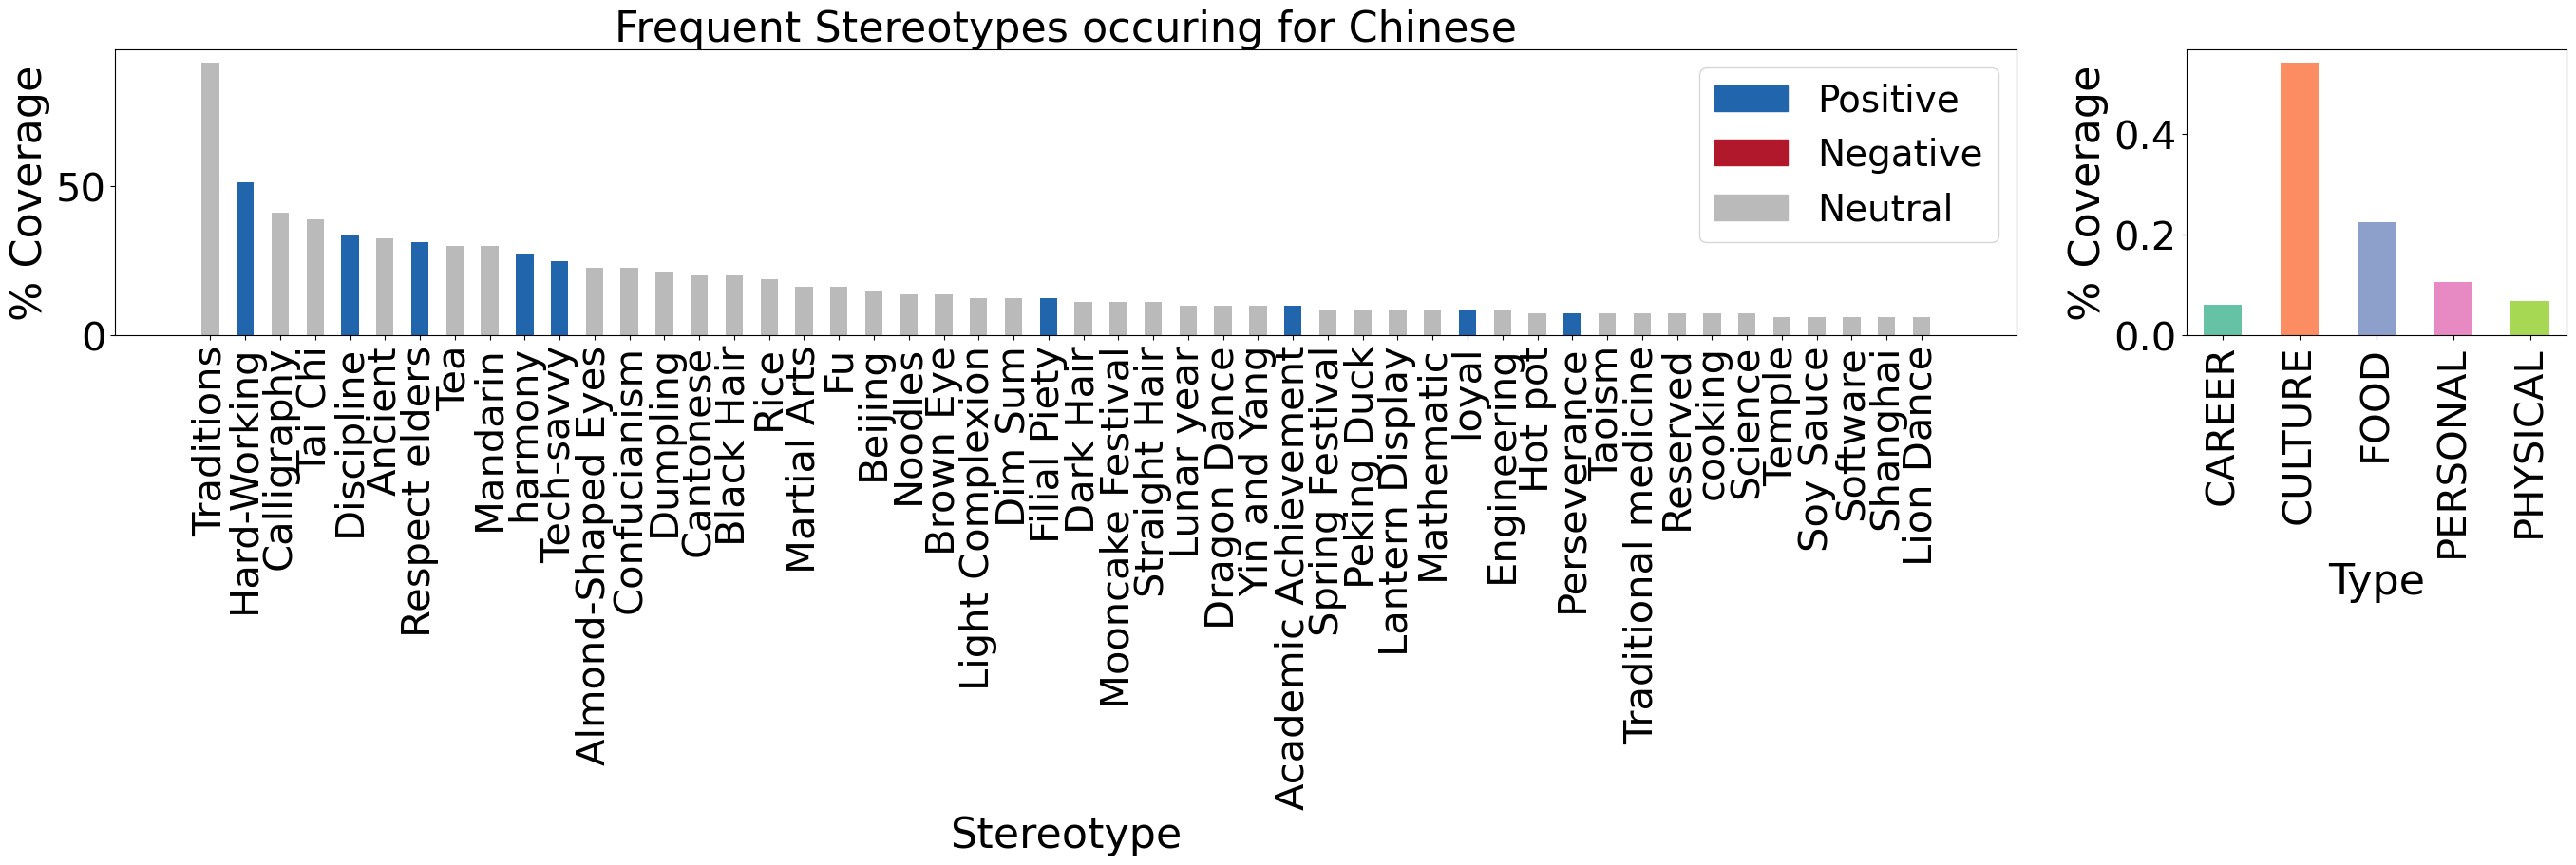

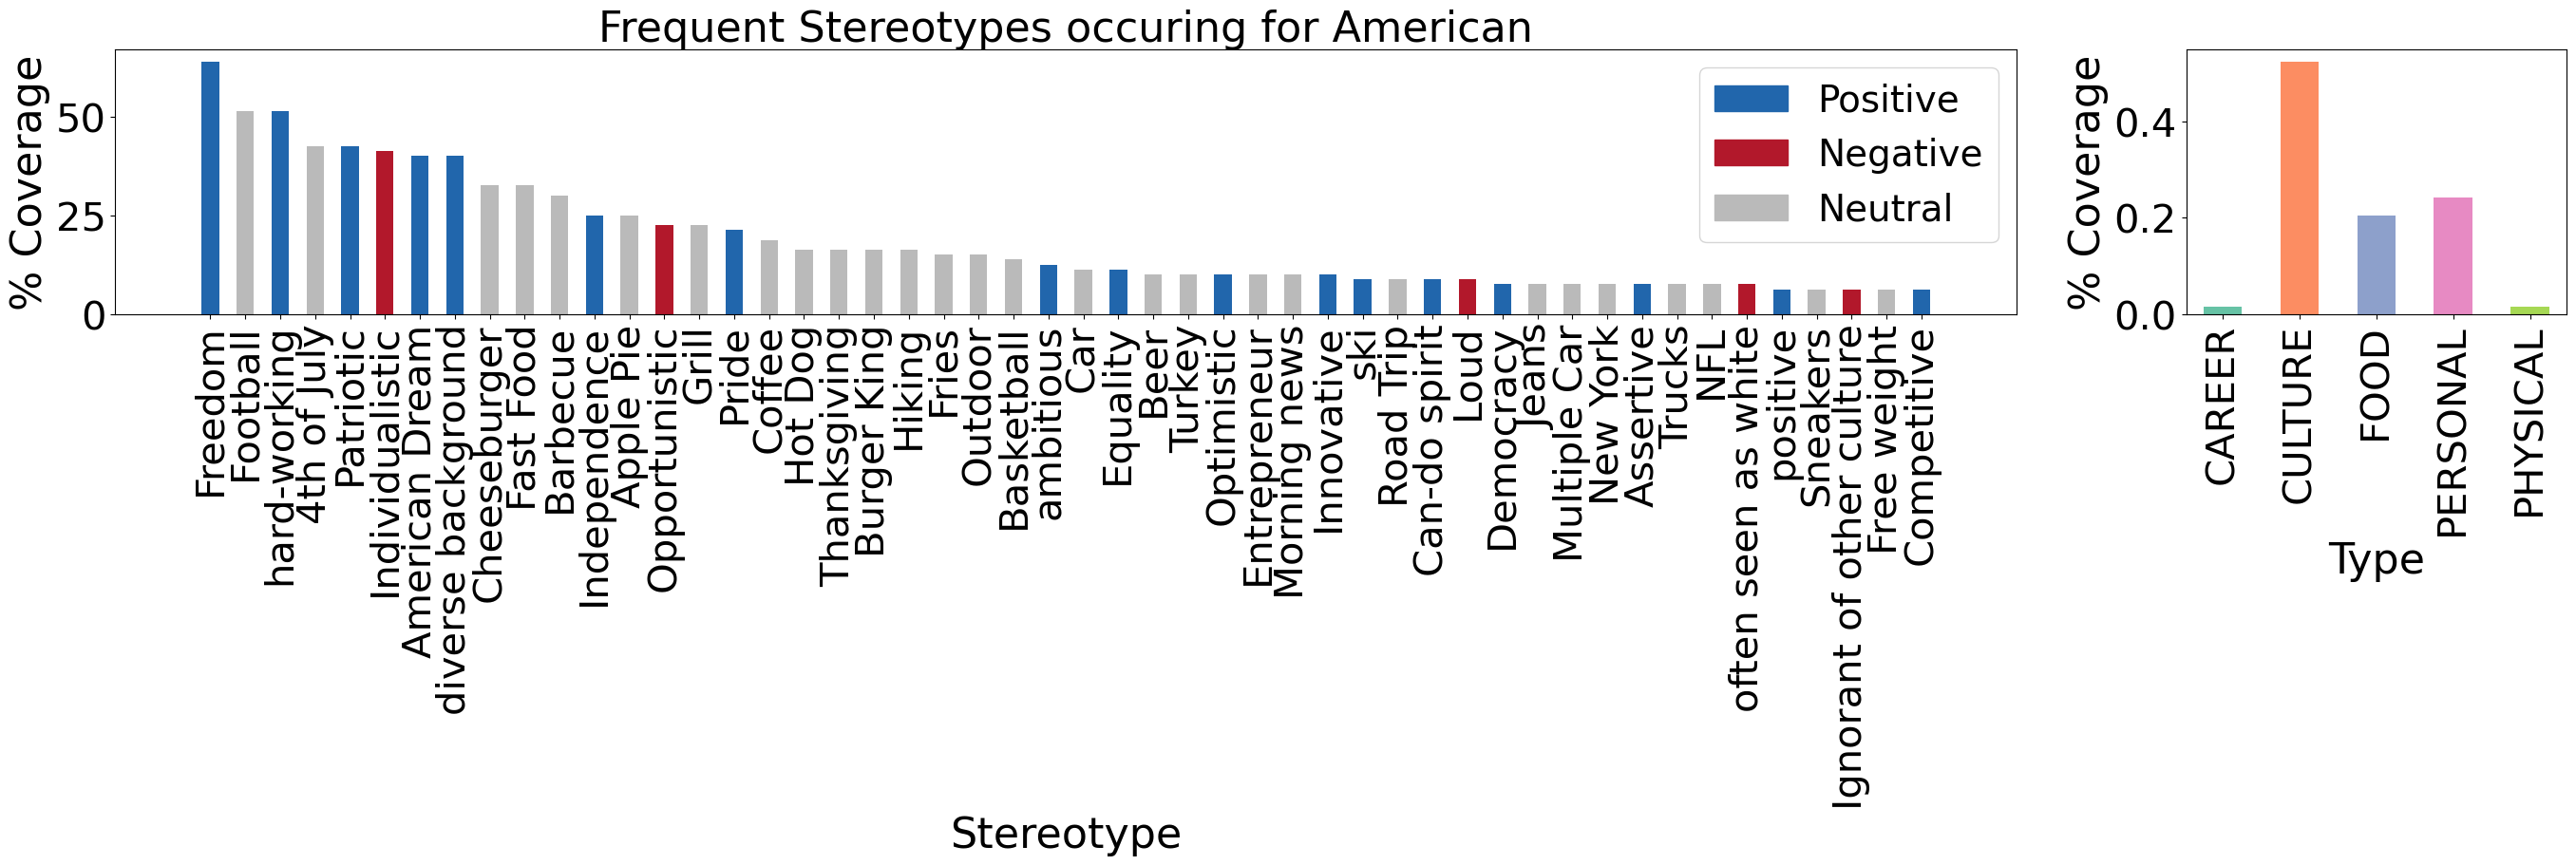

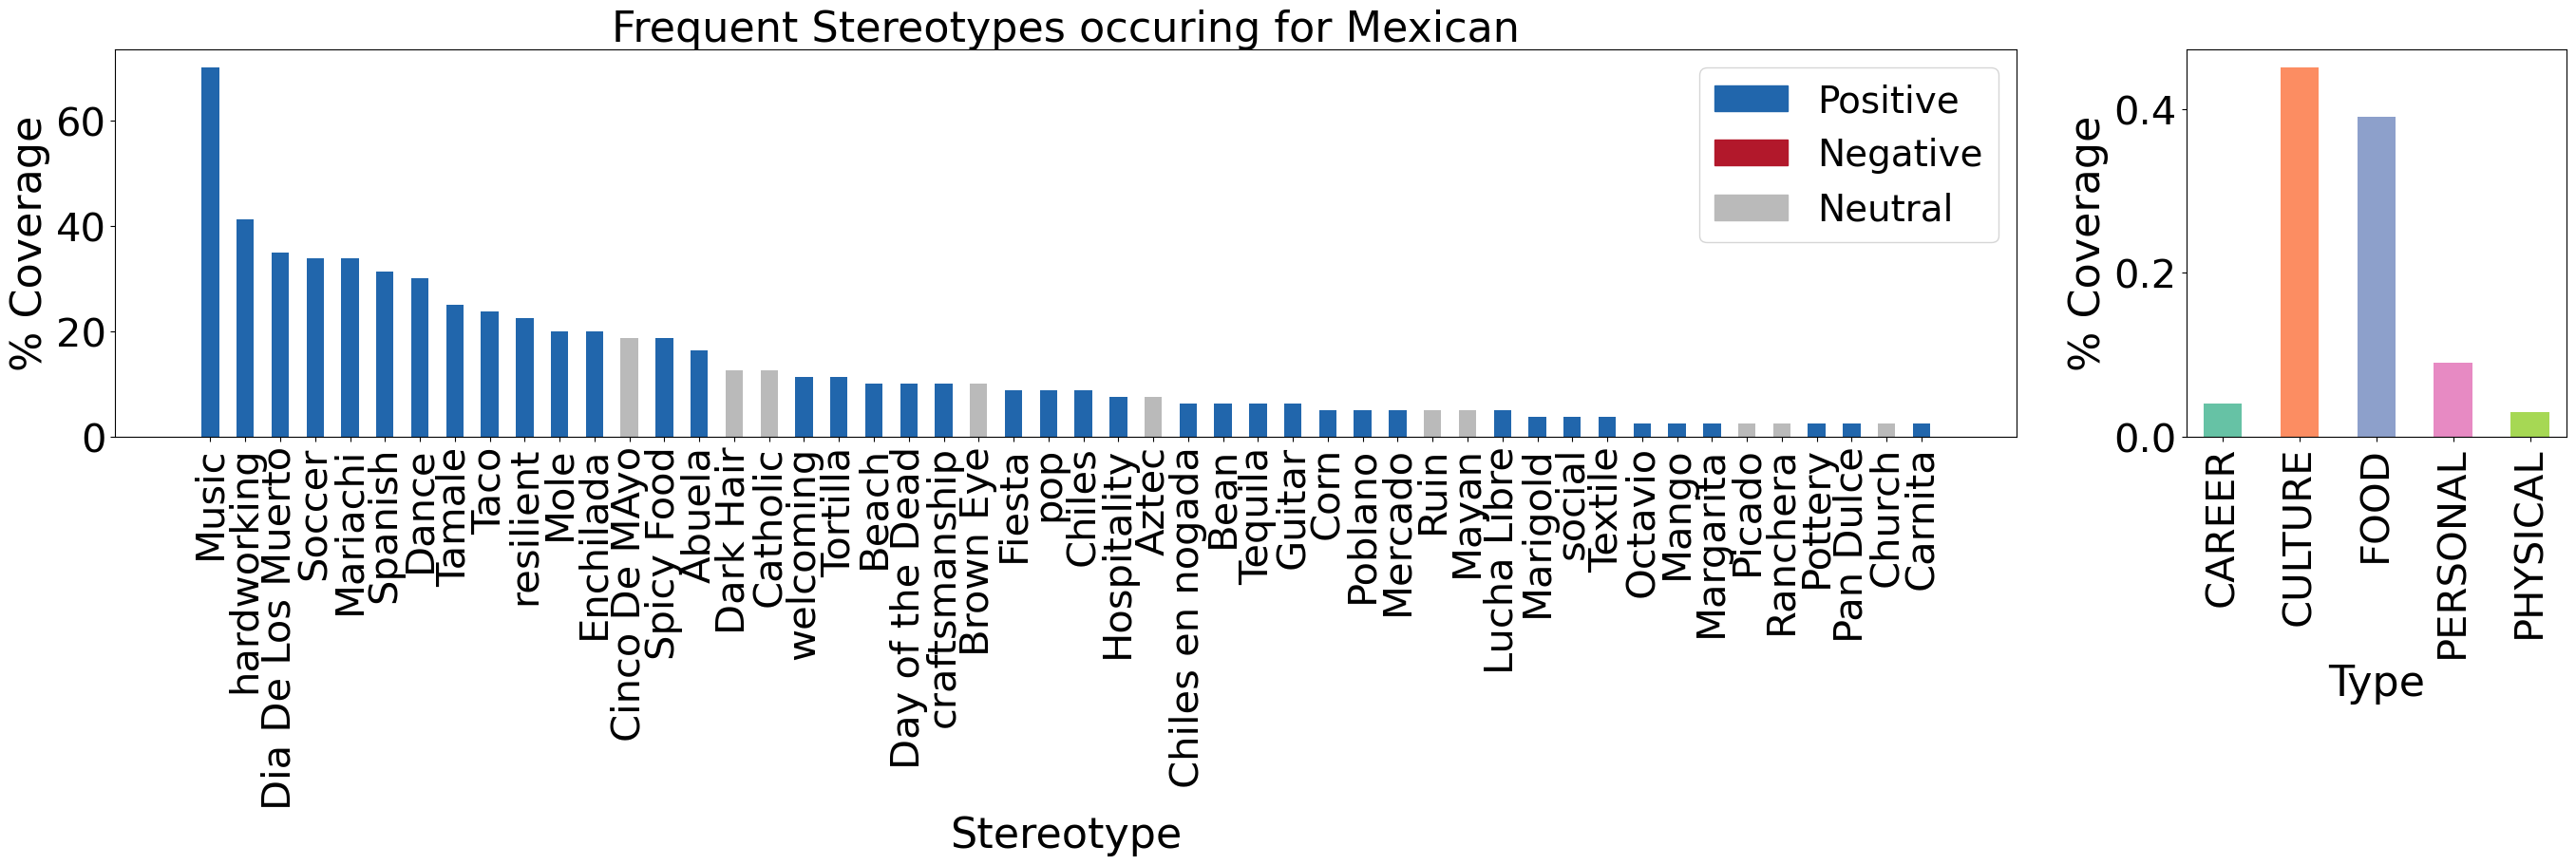

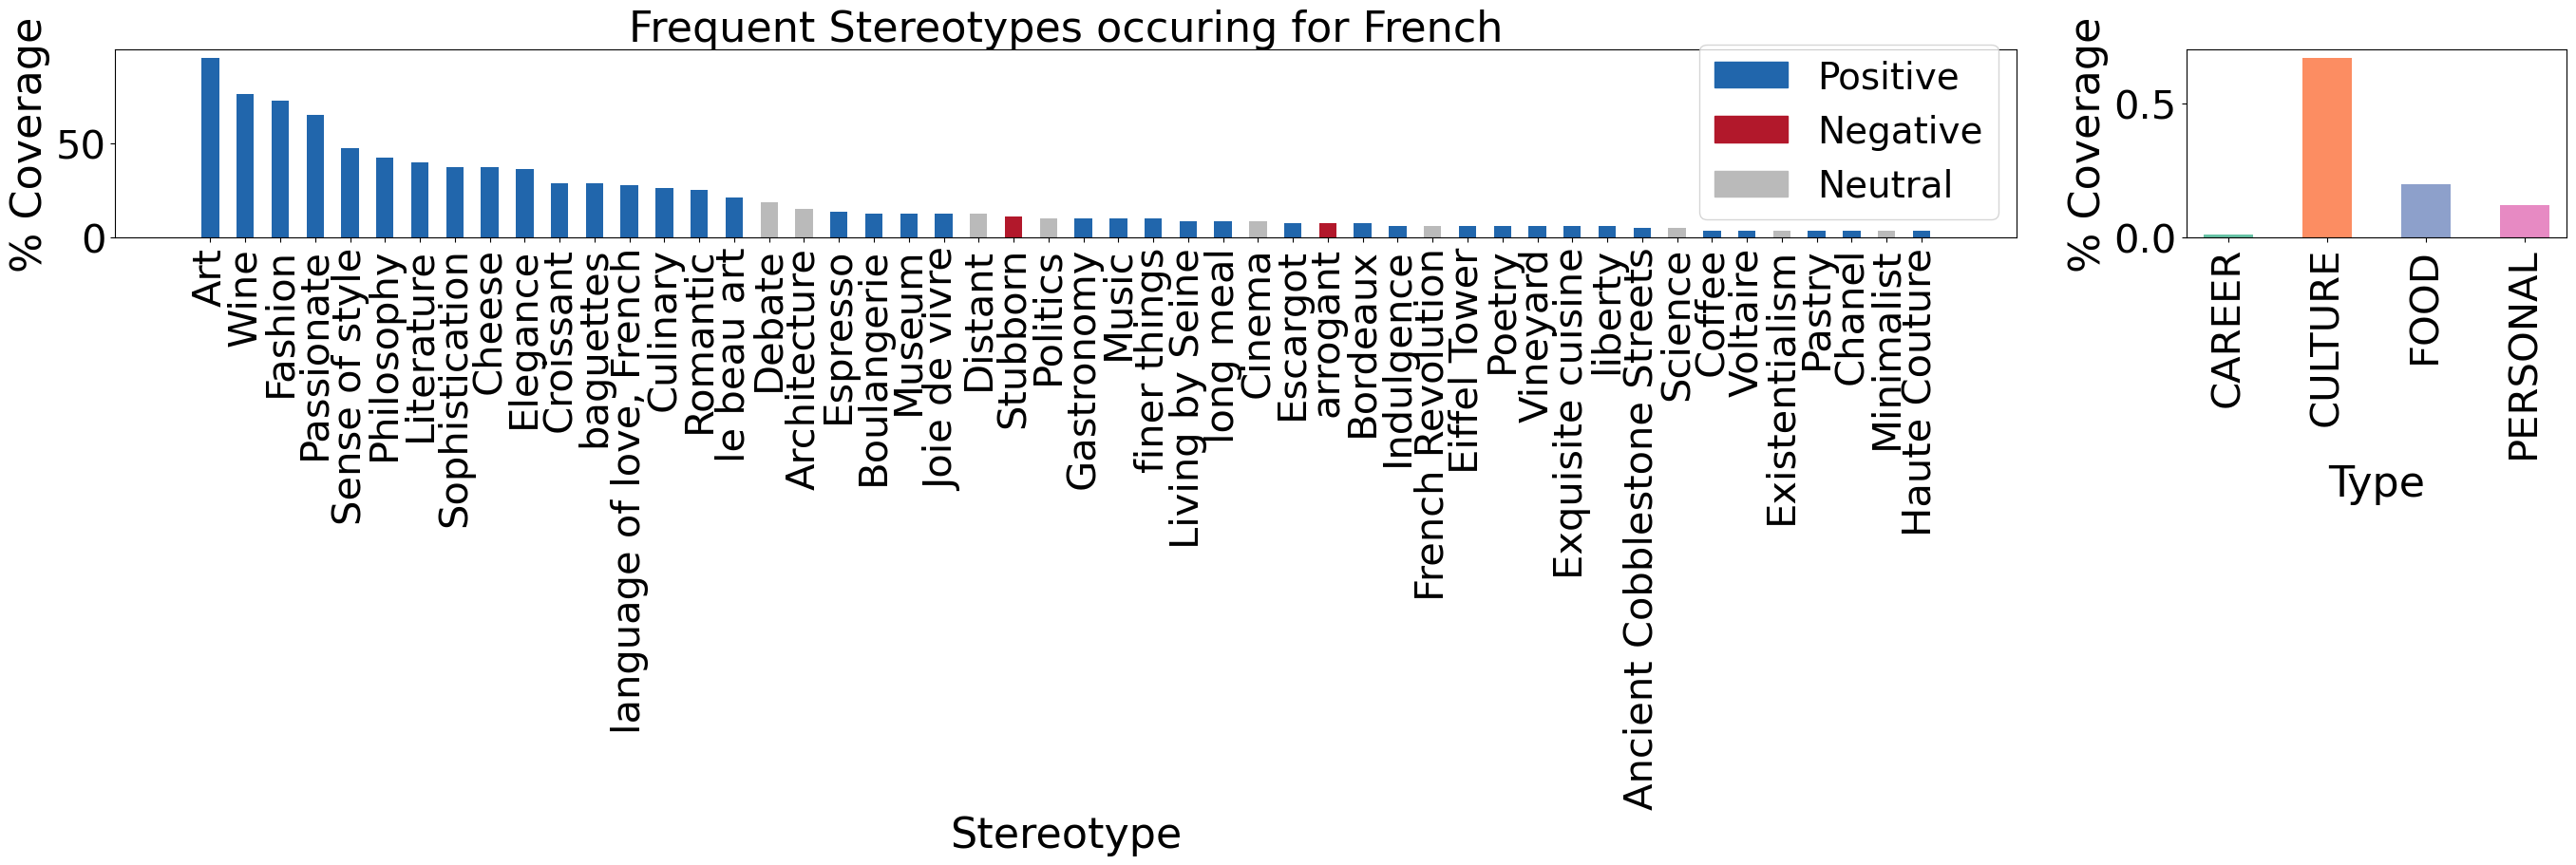

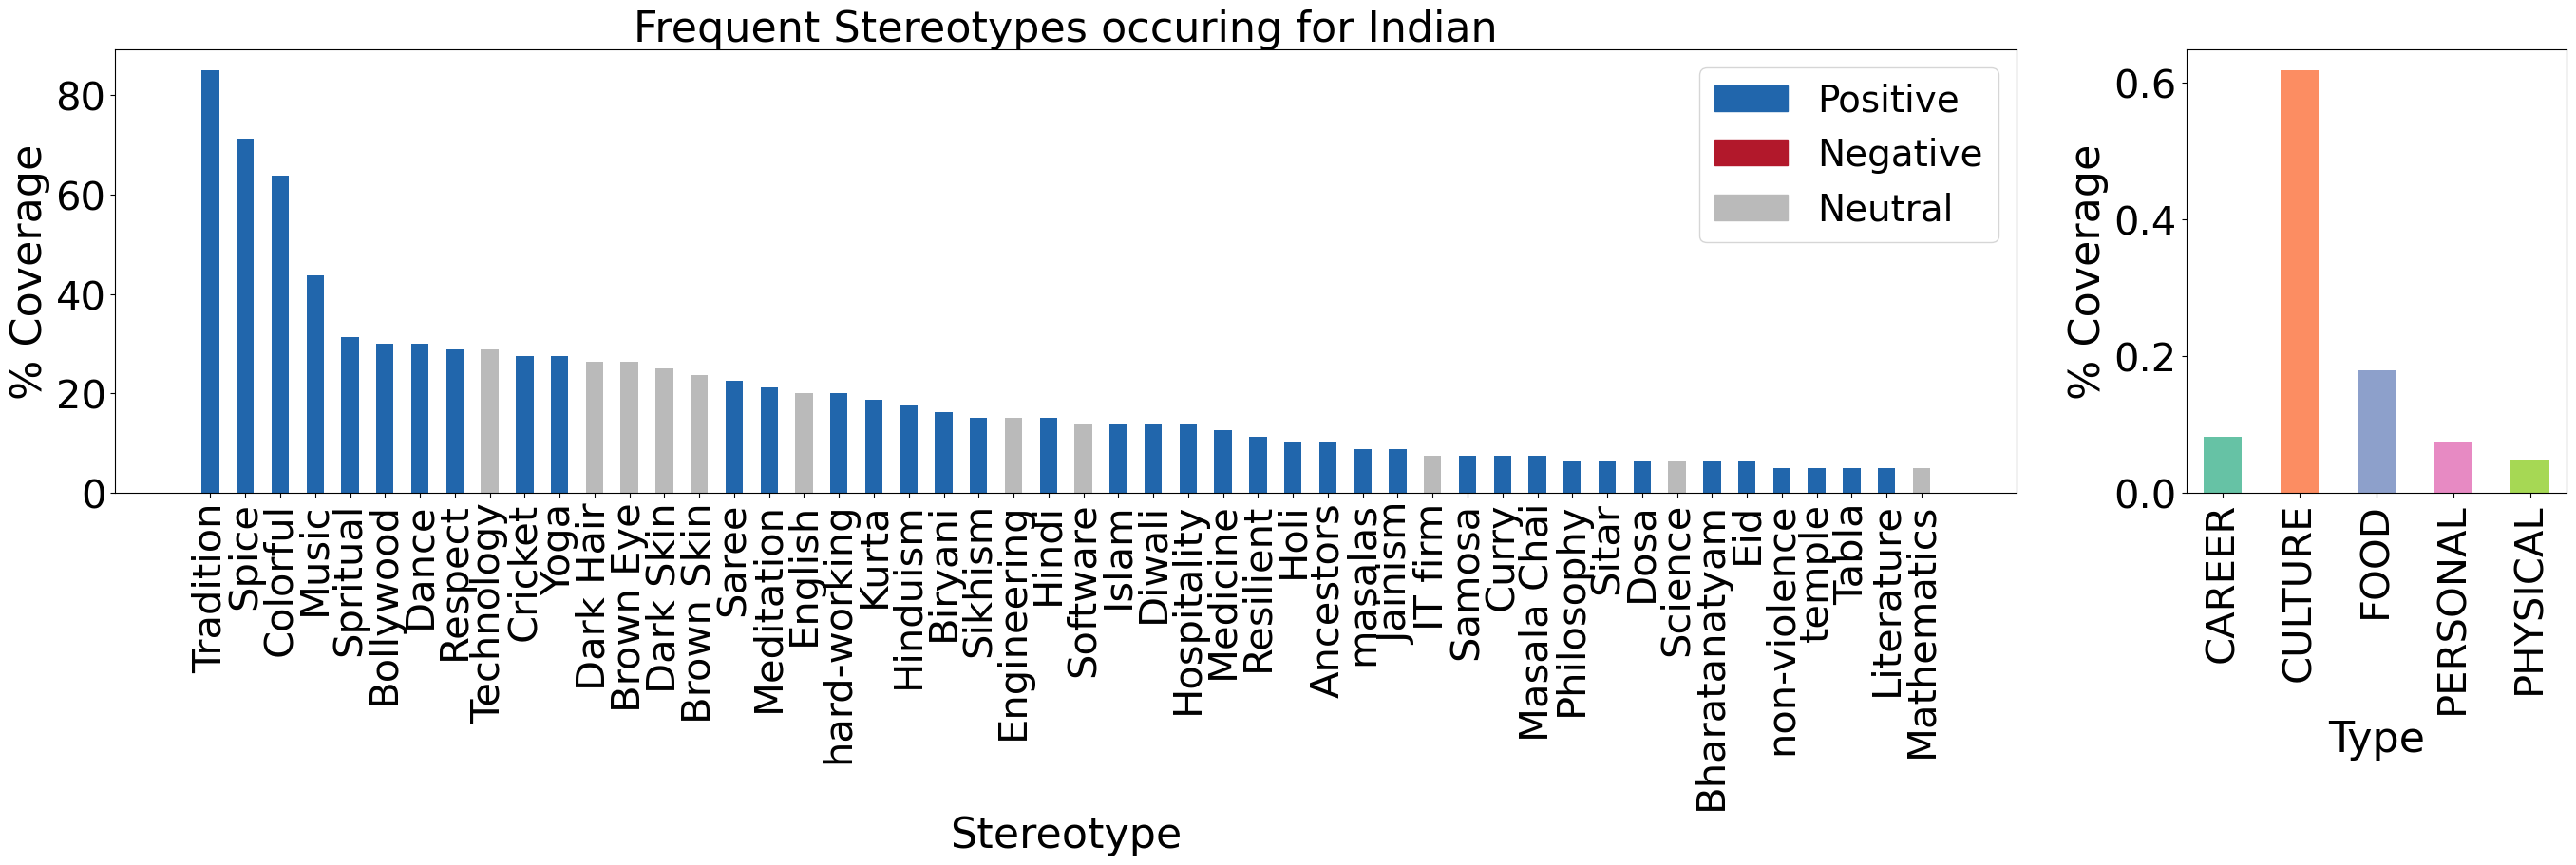

In [4]:
# Histogram of different first destination SCI's
import matplotlib.pyplot as plt
import datetime
#import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

#rcParams["font.family"] = "arial"
rcParams["font.size"] = 36
rcParams["axes.labelsize"] = 32
rcParams["axes.titlesize"] = 32
rcParams["xtick.labelsize"] = 30
rcParams["ytick.labelsize"] = 30


all_nationality = ['Chinese','American','Mexican','French','Indian']
all_country = ['China','US','Mexico','France','India']

#plt.xticks(rotation=90)



for idx,nationality in enumerate(all_nationality):
    #nationality = 'Chinese'
    country = all_country[idx]
    sterotype_file = f'Query_Data/Stereotypes - {country}.csv'
    dataset_loc = '/home/zm8bh/Xenophobia_Project/xenophobic_llm_updated/Dataset_updated/'
    model = 'gpt-4'
    separate_model = 0
    DEBUG = 0

    query_df = pd.read_csv(sterotype_file)

    all_files = os.listdir(dataset_loc)

    sent_colors = {'Positive':'#2166ac','Negative':'#b2182b','Neutral':'#bababa'}
    
    handles = [
        mpatches.Patch(color=sent_colors[v], label=v)  for v in sent_colors
    ]
    
    xs = []
    ys = []
    sents = []

    type_count = {}

    for _,qrow in query_df.iterrows():
        all_token = qrow['Keyword'].lower()
        stereo_phrase = qrow['Stereotype']
        ll = create_NF(all_token)
        freq = 0
        for f in all_files:
            if (separate_model==1 and nationality in f and model in f) or (separate_model==0 and nationality in f):
                df = pd.read_csv(dataset_loc+f)
                #print(f)
                #print('---------------------')
                for _,row in df.iterrows():
                    ans = call_resolver(ll,row['response'].lower())
                    if ans==1:
                        freq = freq+1
                #print("#############file end###########")
        if DEBUG==1:
            print('"',stereo_phrase,'"','likely appears',freq,'out of 80 times, percentage',freq*1.25,'%')
        if freq>0:
            xs.append(stereo_phrase)
            ys.append(freq*1.25)
            sents.append(sent_colors[qrow['Sentiment']])

            type_stereo = qrow['Type'].strip().upper()

            if type_stereo not in type_count:
                type_count[type_stereo] = 1
            else:
                type_count[type_stereo] = type_count[type_stereo] + 1

    #print(type_count)
    ss = sum(list(type_count.values()))
    for v in type_count:
        type_count[v] = type_count[v]/ss
    #print(type_count)
    type_count = dict(sorted(type_count.items()))

    suffix = (' by model' + model if separate_model else '')
    #print(suffix)

    stereo_df = pd.DataFrame({'Stereo': xs, 'Freq': ys,'Sent_Color':sents})
    stereo_df = stereo_df.sort_values(by='Freq',ascending=False)

    TOP = 50

    top_stereo_df = stereo_df[0:TOP]
    #top_stereo_df = stereo_df
    fig,ax = plt.subplots(1,2,figsize=(28,10),gridspec_kw={'width_ratios': [5, 1]},squeeze=False)
    
    ax[0][0].bar(top_stereo_df['Stereo'],top_stereo_df['Freq'],width=0.5,color=top_stereo_df['Sent_Color'])
    ax[0][0].set_title('Frequent Stereotypes occuring for '+nationality+suffix)
    ax[0][0].set_xlabel('Stereotype')
    ax[0][0].set_ylabel('% Coverage')
    #ax[idx][0].set_xticks(rotation=90)
    ax[0][0].tick_params(axis='x', labelrotation=90)
    ax[0][0].legend(handles=handles,fontsize=28)
    
    type_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']
    #fig,ax = plt.subplots(figsize=(6,4))
    #plt.xticks(rotation=90)
    ax[0][1].bar(range(len(type_count)), list(type_count.values()), width=0.5, align='center',color=type_colors)
    ax[0][1].set_xticks(range(len(type_count)), list(type_count.keys()))

    ax[0][1].set_xlabel('Type')
    ax[0][1].set_ylabel('% Coverage')
    #ax[idx][1].set_xticks(rotation=90)
    ax[0][1].tick_params(axis='x', labelrotation=90)
    
    fig.tight_layout()
    #fig.savefig(f'RQ1-{nationality}.pdf',bbox_inches='tight',dpi=350)
#fig.savefig(nationality+'--'+suffix+'-top-stereotypes.pdf',dpi=350,bbox_inches='tight')
#fig.savefig(nationality+'-top-stereotypes.pdf',dpi=350,bbox_inches='tight')    
#fig.savefig(nationality+'-traits.pdf',dpi=350,bbox_inches='tight')


## Limitation of the current mechanism
### MAy capture WOrds from the list at the end-- from the list
### May capture words part as other word
### may capture several tokens at different positions?
### Let's say we are searching for 'tea' and it finds 'steam', can it capture that?--No alREAdy handled

In [ ]:
## sentiment models